In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../chemical_properties_predictor'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
import data_utils as data

%load_ext autoreload

torch.manual_seed(28)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
chembl_path = '../data/ChEMBL_subset.csv'
# chembl_path = '../ChEMBL_subset.csv'

df = pd.read_csv(chembl_path, delimiter = ';')
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL358949,NaN,0,269.32,0,3.48,65,O=c1oc(SCc2ccccc2)nc2ccccc12,Log kOH-,'=',...,ADMET,NaN,ADMET,CHEMBL1125034,1,Scientific Literature,J. Med. Chem.,1990.0,None,NaN
1,CHEMBL70927,DEFERIPRONE,4,139.15,0,0.40,27,Cc1c(O)c(=O)ccn1C,Log K3,'=',...,ADMET,NaN,ADMET,CHEMBL1131072,1,Scientific Literature,J. Med. Chem.,1998.0,None,NaN
2,CHEMBL25110,NaN,0,483.61,1,6.59,1,CC(C)c1cccc(C(C)C)c1OC(=O)[N-]S(=O)(=O)Oc1c(C(...,Unchanged,'=',...,ADMET,NaN,ADMET,CHEMBL1129601,1,Scientific Literature,J. Med. Chem.,1996.0,None,NaN
3,CHEMBL353263,NaN,0,431.44,0,2.98,3o,CN(O)C(=O)Cc1ccc(CC(=O)C2c3cccc(O)c3C(=O)c3c(O...,Activity,'=',...,ADMET,NaN,ADMET,CHEMBL1134364,1,Scientific Literature,J. Med. Chem.,2001.0,CHEMBL3308509,NaN
4,CHEMBL328799,NaN,0,355.16,0,0.01,1f,Nc1nc(=O)n([C@H]2CS[C@@H](CO)O2)cc1I,EC50,'=',...,ADMET,NaN,ADMET,CHEMBL1127218,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1993.0,None,NaN


In [4]:
print(list(df.columns))

['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate', 'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties']


In [5]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['legend.loc'] = 'center right'
plt.rc('axes', labelsize = 18)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.rc('legend', fontsize = 12)

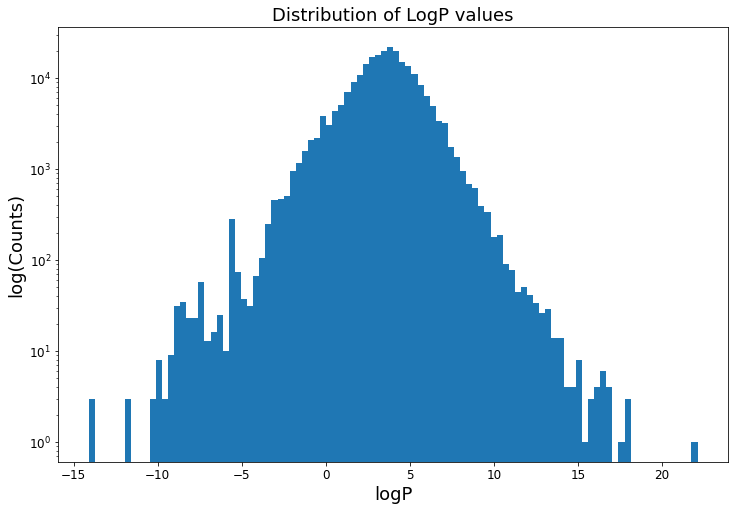

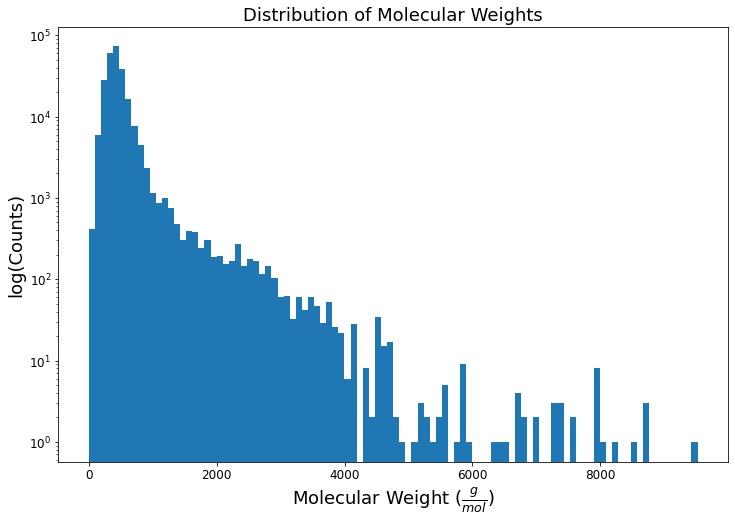

In [6]:
mols = df[['Molecule Name', 'Molecular Weight', 'AlogP', 'Smiles']]
logP_df = mols['AlogP'].replace('None', np.nan)
logP = logP_df.astype('float').tolist()
logP[:10]

fig, ax = plt.subplots(figsize = (12, 8))
n, bins, patches = plt.hist(logP, bins = 100)
plt.title('Distribution of LogP values', fontsize = 18)
ax.set_yscale('log')
ax.set_xlabel('logP')
ax.set_ylabel('log(Counts)')
plt.show()

mw_df = mols['Molecular Weight'].replace('None', np.nan)
mw = mw_df.astype('float').tolist()

fig, ax = plt.subplots(figsize = (12, 8))
n, bins, patches = plt.hist(mw, bins = 100)
plt.title('Distribution of Molecular Weights', fontsize = 18)
ax.set_yscale('log')
ax.set_xlabel('Molecular Weight ($\\frac{g}{mol}$)')
ax.set_ylabel('log(Counts)')
plt.show()

1489


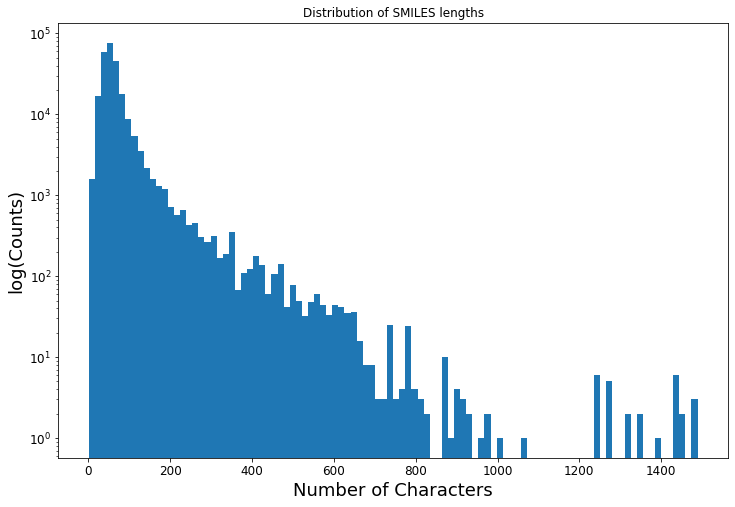

In [7]:
smiles = mols['Smiles'].dropna().tolist()
smiles_lengths = [len(list(x)) for x in smiles]
print(max(smiles_lengths))

fig, ax = plt.subplots(figsize = (12, 8))
n, bins, patches = plt.hist(smiles_lengths, bins = 100)
plt.title('Distribution of SMILES lengths')
ax.set_yscale('log')
ax.set_xlabel('Number of Characters')
ax.set_ylabel('log(Counts)')
plt.show()

(229516, 3)


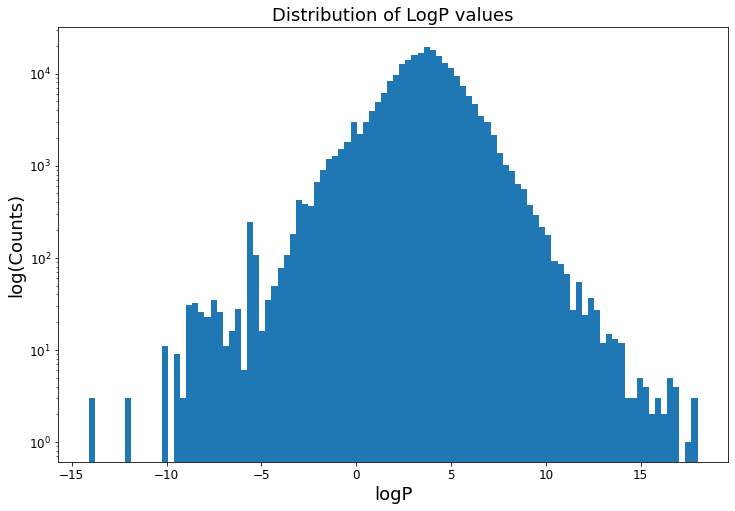

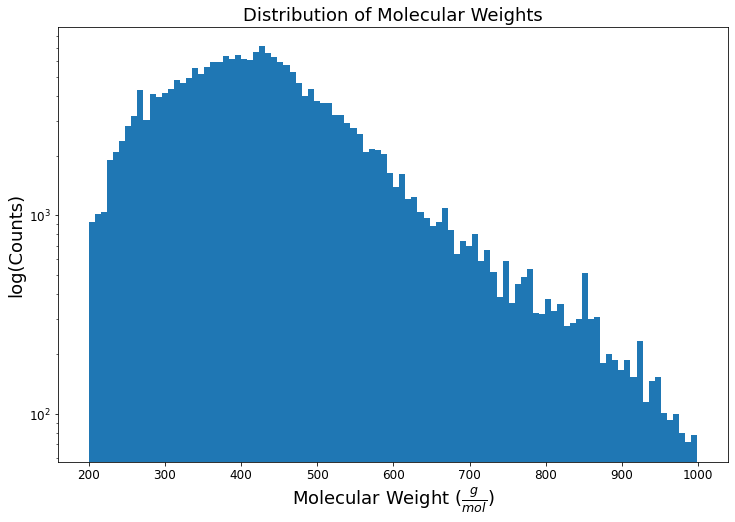

247


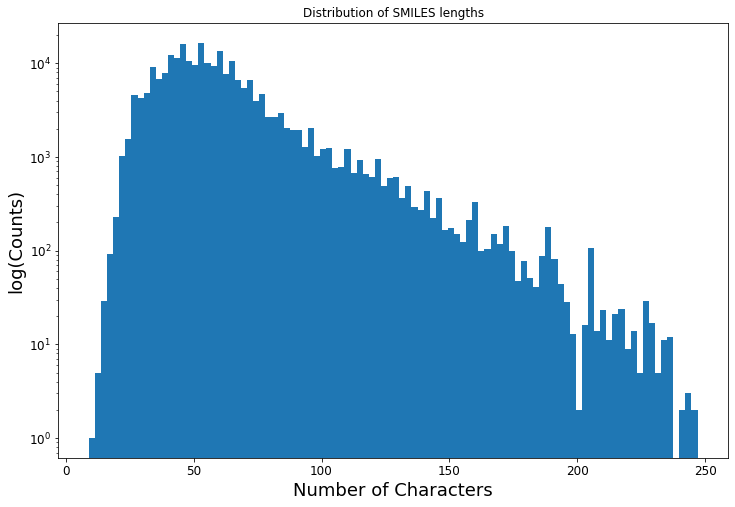

In [8]:
#Use SMILES and MW to predict logP

#drop all rows with a nan in the 3 columns of interest
mols_df = mols[['Smiles', 'Molecular Weight', 'AlogP']].replace('None', np.nan)
mols_df = mols_df.dropna()
mols_df = mols_df.astype({'Smiles':str, 'Molecular Weight': np.float, 'AlogP': np.float})

#filter out molecules that are too large or too small
mols_df = mols_df.query('`Molecular Weight` <= 1000')
mols_df = mols_df.query('`Molecular Weight` >= 200')

#Take every 10th sample to create toy dataset
print(mols_df.shape)
# mols_df = mols_df.iloc[lambda x: x.index % 10 == 0]
# print(mols_df.shape)

logP_df = mols_df['AlogP'].replace('None', np.nan)
logP = logP_df.astype('float').tolist()
logP[:10]

fig, ax = plt.subplots(figsize = (12, 8))
n, bins, patches = plt.hist(logP, bins = 100)
plt.title('Distribution of LogP values', fontsize = 18)
ax.set_yscale('log')
ax.set_xlabel('logP')
ax.set_ylabel('log(Counts)')
plt.show()

mw_df = mols_df['Molecular Weight'].replace('None', np.nan)
mw = mw_df.astype('float').tolist()

fig, ax = plt.subplots(figsize = (12, 8))
n, bins, patches = plt.hist(mw, bins = 100)
plt.title('Distribution of Molecular Weights', fontsize = 18)
ax.set_yscale('log')
ax.set_xlabel('Molecular Weight ($\\frac{g}{mol}$)')
ax.set_ylabel('log(Counts)')
plt.show()

smiles = mols_df['Smiles'].dropna().tolist()
smiles_lengths = [len(list(x)) for x in smiles]
print(max(smiles_lengths))

fig, ax = plt.subplots(figsize = (12, 8))
n, bins, patches = plt.hist(smiles_lengths, bins = 100)
plt.title('Distribution of SMILES lengths')
ax.set_yscale('log')
ax.set_xlabel('Number of Characters')
ax.set_ylabel('log(Counts)')
plt.show()

In [9]:
X = mols_df[['Smiles', 'Molecular Weight']]
Y = mols_df['AlogP']
Y = Y.astype('float')

x_tr, x_ts, y_tr, y_ts = train_test_split(X, Y)
print(x_tr.shape)
print(x_ts.shape)

(172137, 2)
(57379, 2)


In [10]:
print(x_tr.shape)
print(type(x_tr.iloc[0][0]))
print(x_tr.iloc[214])
print(y_tr.iloc[8])

print(y_tr.shape)
print(len(y_tr.shape))

(172137, 2)
<class 'str'>
Smiles              O=C(O)C1(c2ccc(-c3ccc(C(F)(F)F)cc3)c(F)c2)CC1
Molecular Weight                                           324.27
Name: 90437, dtype: object
2.9
(172137,)
1


In [11]:
%autoreload

#normalize all datasets
#the key can be used to denormalize datasets to their original values during post-processing
x_tr, x_tr_key = data.df_MinMax_normalize(x_tr)
y_tr, y_tr_key = data.df_MinMax_normalize(y_tr)
x_ts, x_ts_key = data.df_MinMax_normalize(x_ts)
y_ts, y_ts_key = data.df_MinMax_normalize(y_ts)

x_tr

,Smiles,Molecular Weight
143172,C[C@@H](c1ccc(-c2cccc(-c3noc(O)n3)c2)cc1)[C@H]...,0.406027
129073,O=C(CCOCCN1CCN(c2cccnc2-c2ccc(F)cc2)CC1)NCc1cc...,0.413661
140520,COCCCOc1cccc([C@H]2NC(=S)Nc3c2oc2ncccc32)c1,0.212024
58861,CC(C)C(NC(=O)N(C)Cc1csc(C2CC2)n1)C(=O)N[C@@H](...,0.649413
38786,O=C(O)c1cccc(Cn2cnc3ccccc32)c1,0.065377
...,...,...
60193,N=C(N)NC(=O)c1nc(Cl)c(N)nc1N,0.037044
69105,COc1ccc(C(=O)CNC(=O)[C@H](CCCCNC(C)=S)NC(=O)OC...,0.357395
22365,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,0.040310
120912,C=CCc1ccc(O)c(-c2ccc(O)c(CC=C)c2)c1,0.082985


In [12]:
%autoreload

train_dataset = data.ChemDataset(x_tr, y_tr)
test_dataset = data.ChemDataset(x_ts, y_ts)
print(train_dataset[8])

batchsize = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batchsize,
                                           shuffle = True, num_workers = 4,
                                           drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batchsize,
                                          shuffle = True, num_workers = 4,
                                          drop_last = True)

(array([29, 33, 40, 16, 40, 40,  4, 33, 29,  5, 40, 17, 43, 43, 40, 18, 40,
        4, 40,  4,  7, 40, 19, 40, 40, 40, 43, 40, 19, 29,  5, 43, 43, 18,
       29,  5, 40, 17, 40, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  

In [13]:
%autoreload

num_epochs = 10
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
%autoreload

model = models.LinearLogP(n_hidden = 1000,
                       batchsize = batchsize,
                       embedding_dims = 10)
model.apply(models.init_weights)
model.to(torch.double)

#This is crucial for utilizing GPU and ensuring that all tensors and models 
#are on the same device
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
    
model.to(device)

#to utilize multiple GPUs, follow this tutorial:
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/63ecfdf27b96977f3a89015f60065a2b/data_parallel_tutorial.ipynb

optimizer = torch.optim.AdamW(params = model.parameters(), lr = learning_rate)

In [20]:
%autoreload

train_epochs = []
test_epochs = []

results = {}

for epoch in range(num_epochs):
    model, train_loss, train_parity = models.train_logP(model, train_loader, optimizer)
    train_epochs.append(train_loss)
    
    test_loss, test_parity = models.test_logP(model, test_loader)
    test_epochs.append(test_loss)
    
    results[epoch] = {'train': train_parity,
                      'test': test_parity}
    
    print(f'--------------------{epoch}-------------------')

100%|██████████| 1344/1344 [01:56<00:00, 11.57it/s]


--------------------0-------------------


100%|██████████| 1344/1344 [01:56<00:00, 11.49it/s]


--------------------1-------------------


100%|██████████| 1344/1344 [01:56<00:00, 11.55it/s]


--------------------2-------------------


100%|██████████| 1344/1344 [01:56<00:00, 11.57it/s]


--------------------3-------------------


100%|██████████| 1344/1344 [01:56<00:00, 11.51it/s]


--------------------4-------------------


100%|██████████| 1344/1344 [01:56<00:00, 11.51it/s]


--------------------5-------------------


100%|██████████| 1344/1344 [01:55<00:00, 11.66it/s]


--------------------6-------------------


100%|██████████| 1344/1344 [01:57<00:00, 11.45it/s]


--------------------7-------------------


100%|██████████| 1344/1344 [01:55<00:00, 11.68it/s]


--------------------8-------------------


100%|██████████| 1344/1344 [01:55<00:00, 11.67it/s]


--------------------9-------------------


[0.0016170344551016118, 0.0006518852429875344, 0.000539130123728167, 0.00045881166751406594, 0.0004158568942023569, 0.00040069573496007176, 0.0003606213465675784, 0.000327919273231128, 0.0003155698326724624, 0.00029754743653945964]
[0.0007537637701187915, 0.0006895501557853401, 0.0005356900151300367, 0.0005340333571832016, 0.0004892861643390821, 0.0005703122835883942, 0.00044974850503092374, 0.0004639173192061259, 0.00044499037344564006, 0.00040371346560935645]


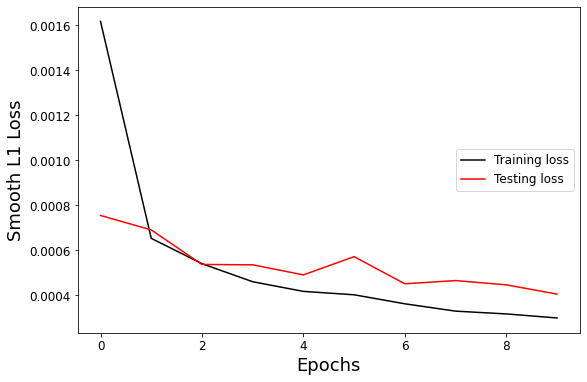

In [21]:
test_epochs = [x.cpu() for x in test_epochs]
test_epochs = [x.item() for x in test_epochs]
print(train_epochs)
print(test_epochs)

epochs = range(0, num_epochs)

fig, ax = plt.subplots(figsize = (9, 6))
ax.plot(epochs, train_epochs, c = 'k', label = 'Training loss')
ax.plot(epochs, test_epochs, c = 'r', label = 'Testing loss')
ax.legend()
ax.set_ylabel('Smooth L1 Loss')
ax.set_xlabel('Epochs')

plt.show()

In [22]:
last_ep = num_epochs - 1

train_targs = results[last_ep]['train']['targets']
train_preds = results[last_ep]['train']['predictions']

test_targs = results[last_ep]['test']['targets']
test_preds = results[last_ep]['test']['predictions']

print(len(test_targs))
print(len(test_preds))

448
448


In [27]:
test_preds[-1][-1]

[[0.49559682038952435]]

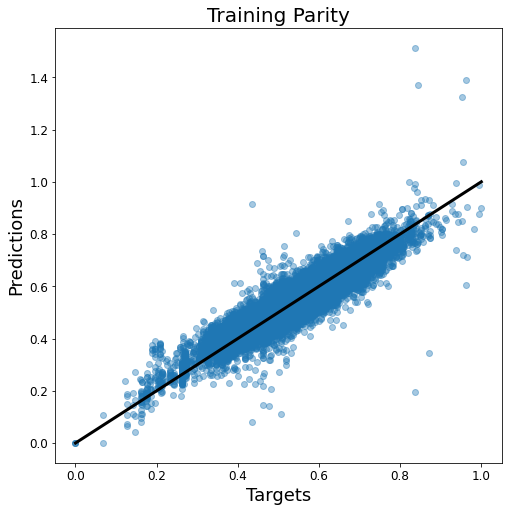

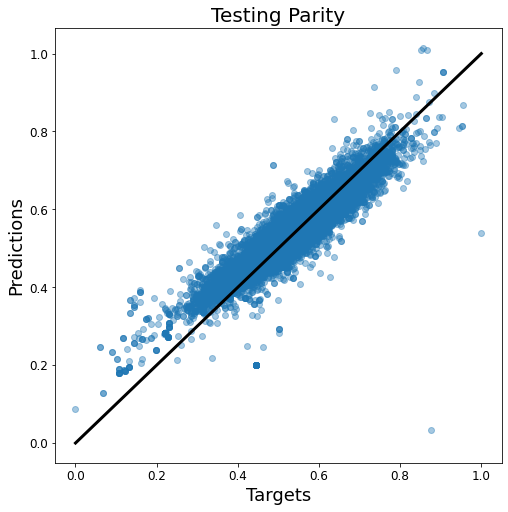

In [37]:
from sklearn.metrics import r2_score

# train_r2 = r2_score(train_targs, train_preds)
# test_r2 = r2_score(test_targs, test_preds)

linear_x = np.linspace(0, 1, num = 3)
linear_y = np.linspace(0, 1, num = 3)

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(train_targs, train_preds, alpha = 0.4)
ax.plot(linear_x, linear_y, c = 'k', linewidth = 3)
ax.set_ylabel('Predictions')
ax.set_xlabel('Targets')
ax.set_title('Training Parity', fontsize = 20)
# ax.annotate(f'$R^2$ = {train_r2}', xy = (0.25, 0.75),
#             xycoords = 'axes fraction')
plt.show()

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(test_targs, test_preds, alpha = 0.4)
ax.plot(linear_x, linear_y, c = 'k', linewidth = 3)
ax.set_ylabel('Predictions')
ax.set_xlabel('Targets')
ax.set_title('Testing Parity', fontsize = 20)
# ax.annotate(f'$R^2$ = {test_r2}', xy = (0.25, 0.75),
#             xycoords = 'axes fraction')
plt.show()

In [ ]:
#dev space for using nn.Embedding, rather than sklear.preprocessing.OneHotEncoder

#'*' represents the padding character to ensure that the SMILES strings are all uniform in size
SMILES_CHARS = [['*'], [' '], ['#'], ['%'], ['('], [')'], ['+'], ['-'], ['.'], ['/'], ['='], ['@'],
                ['['], ['\\'], [']'], ['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'],
                ['9'], ['A'], ['B'], ['C'], ['F'], ['H'], ['I'], ['K'], ['L'], ['M'], ['N'], ['O'],
                ['P'], ['R'], ['S'], ['T'], ['V'], ['X'], ['Z'], ['a'], ['b'], ['c'], ['e'], ['g'],
                ['i'], ['l'], ['n'], ['o'], ['p'], ['r'], ['s'], ['t'], ['u']]

num_chars = len(SMILES_CHARS)
print(num_chars)

embedding = nn.Embedding(num_embeddings = num_chars, embedding_dim = 10, padding_idx = 0)

def pad(smiles_str):
    if len(smiles_str) < 250:
        pad_len = 250 - len(smiles_str)
        pad_str = ''

        for i in range(pad_len):
            pad_str = pad_str + '*'

        padded_str = smiles_str + pad_str

    else:
        padded_str = smiles_str

    return padded_str

57


In [ ]:
smiles_idx = [SMILES_CHARS.index(x) for x in SMILES_CHARS]

smiles_key = {}

for sm, ix in zip(SMILES_CHARS, smiles_idx):
    smiles_key[ix] = sm
    
smiles_key

{0: ['*'],
 1: [' '],
 2: ['#'],
 3: ['%'],
 4: ['('],
 5: [')'],
 6: ['+'],
 7: ['-'],
 8: ['.'],
 9: ['/'],
 10: ['='],
 11: ['@'],
 12: ['['],
 13: ['\\'],
 14: [']'],
 15: ['0'],
 16: ['1'],
 17: ['2'],
 18: ['3'],
 19: ['4'],
 20: ['5'],
 21: ['6'],
 22: ['7'],
 23: ['8'],
 24: ['9'],
 25: ['A'],
 26: ['B'],
 27: ['C'],
 28: ['F'],
 29: ['H'],
 30: ['I'],
 31: ['K'],
 32: ['L'],
 33: ['M'],
 34: ['N'],
 35: ['O'],
 36: ['P'],
 37: ['R'],
 38: ['S'],
 39: ['T'],
 40: ['V'],
 41: ['X'],
 42: ['Z'],
 43: ['a'],
 44: ['b'],
 45: ['c'],
 46: ['e'],
 47: ['g'],
 48: ['i'],
 49: ['l'],
 50: ['n'],
 51: ['o'],
 52: ['p'],
 53: ['r'],
 54: ['s'],
 55: ['t'],
 56: ['u']}

In [ ]:
#pad and tokenize string
test_str = x_tr['Smiles'][0]
padded = pad(test_str)
str_list = [[x] for x in padded]
print(str_list)
print(len(str_list))

idx_list = []

#convert tokenized string to integer indexes of SMILES chars
for char in str_list:
    idx = list(smiles_key.values()).index(char)
    idx_list.append(idx)
    
print(idx_list)
print(len(idx_list))

#convert list of indexes to np.array and then torch.tensor
idx_array = np.array(idx_list)
idx_tense = torch.from_numpy(idx_array)
test_emb = embedding(idx_tense)
print(test_emb.size())
test_emb

[['O'], ['='], ['c'], ['1'], ['o'], ['c'], ['('], ['S'], ['C'], ['c'], ['2'], ['c'], ['c'], ['c'], ['c'], ['c'], ['2'], [')'], ['n'], ['c'], ['2'], ['c'], ['c'], ['c'], ['c'], ['c'], ['1'], ['2'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*'], ['*']

tensor([[ 0.6777, -0.6128,  0.8566,  ..., -0.8668,  0.7752,  1.6706],
        [ 1.4681,  1.3333, -0.8984,  ..., -0.0345, -0.5235, -0.8488],
        [-2.0019, -0.0075,  0.9712,  ..., -0.3245, -0.2680,  0.8916],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<EmbeddingBackward>)

In [74]:
char_dict = np.load('C:\\Users\\tatum\\Downloads\\char_dict_zinc.pkl', allow_pickle = True)

char_dict

{'<start>': 0,
 'C': 1,
 'c': 2,
 '1': 3,
 '(': 4,
 ')': 5,
 'N': 6,
 '=': 7,
 'S': 8,
 '2': 9,
 'O': 10,
 '3': 11,
 'F': 12,
 'n': 13,
 's': 14,
 '-': 15,
 'Cl': 16,
 '4': 17,
 '5': 18,
 '6': 19,
 'Br': 20,
 '[nH]': 21,
 '#': 22,
 'o': 23,
 '_': 24,
 '<end>': 25}